In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import get_csv_row_count
from models.utils import get_folder_path
from models.utils import fit_circle
from models.utils import plot_column_histograms
import time
import csv
import scipy.stats as sc

Thrash particle initialized to get reference trajectory
[15.59403485 15.31101522 17.10080993 14.10542168 16.77777225 15.94134371
 14.89168077 16.28566435 16.12399922 15.99772445 14.85632849 13.69083802
 15.23598039 16.17540583 14.86533453 15.73879324 15.2824387  14.41686981
 15.86330942 15.26084331 15.97177368 15.38862652 15.07355554 16.06510881
 15.53197027 15.45097937 15.77265681 16.23554949 16.4404488  15.38633822
 15.47682764 13.7285024  17.39245773 15.18182508 14.98892602 14.29165811
 14.89242802 15.94340414 15.26775157 14.86294005 15.51191704 14.6985876
 16.847093   14.04611842 14.21938275 15.52947633 14.8129704  15.23107211
 15.93081564 15.20081247 14.53732296 15.56557154 15.56125259 15.32506203
 14.94247172 14.34649521 15.77022357 14.88765855 15.1038497  16.83826042
 15.59608079 15.36987801 15.29815401 15.02184141 17.00921354 15.23238074
 15.80545437 16.45664794 14.87607385 14.72403224 15.78542129 14.64797343
 15.56590928 15.21695642 16.15892453 14.14205621 17.61854105 15.33818

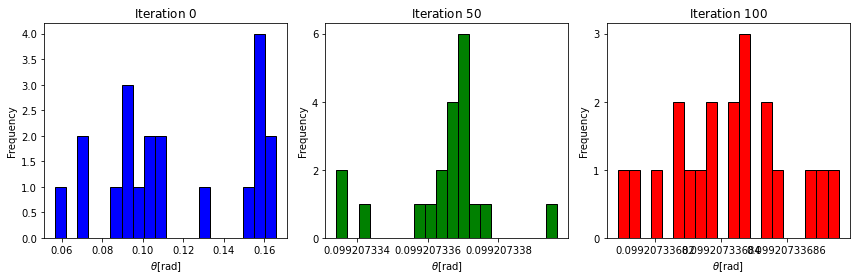

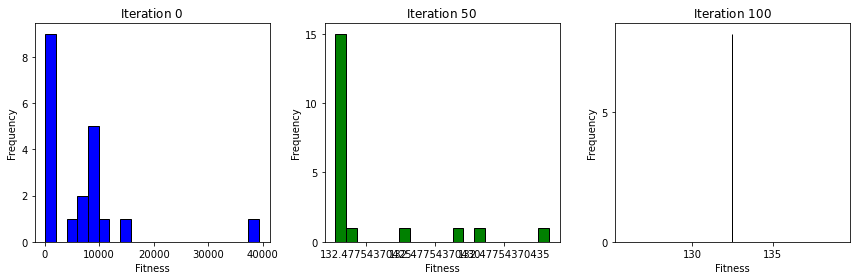

array([[0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734],
       [0.09920734]])

In [3]:
##FINAL VERSION WITH FITNESS FUNCTION NOT COMPUTED EVRY TIME
data_size = 100

np.random.seed(2)

class Particle:
    def __init__(self, position, velocity,id, dimension, x_ref):
        # Necessary for all the particles iincluding thrash one
        self.dt = 0.025
        self.commands = get_folder_path()+'/open_loop_inputs/open_loop_commands.csv'
        self.N = get_csv_row_count(self.commands)
        self.open_loop_tf = self.N*self.dt

        dt = 0.05
        open_loop_tf = 10000
        T_peak = 0.37
        T_slope = 0.4
        

        self.model4 = FourWheelModel(dt, open_loop_tf, T_peak, T_slope)

        if id != 9999999999: # Avoid constructor for  thrash particle
            self.position = position
            self.velocity = velocity
            self.best_position = position.copy()
            self.dimension = dimension

            #related to vehicle model
            self.param_to_infer = 2
            self.x_scal_ref = x_ref
            self.x_vect_ref = x_ref
            self.model = None
            # T_peak and T_slope is not specified since we infer those
            self.id = id

            
            self.position_cost_value = self.compute_fitness_function()
            self.best_position_cost_value = float(self.position_cost_value)


    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        
        self.position += self.velocity
        self.position = np.clip(self.position, lower_bounds, upper_bounds)
        self.position_cost_value = self.compute_fitness_function()

    def update_best_position(self):
        if self.position_cost_value < self.best_position_cost_value:
            self.best_position = self.position.copy()
            self.best_position_cost_value = self.position_cost_value
    
    def compute_fitness_function(self):
        return float(self.get_kpi())
    
    def get_kpi(self):
        
        
        return self.lhd()
        #return (self.model4.kinematik_model_radius(self.position)-self.get_x_scal_ref())**2 #for dirac
    
    def get_x_scal_ref(self):
        return self.model4.kinematik_model_radius(0.1)
    
    def get_x_vect_ref(self):
        
        steering = np.full(data_size,0.1)

        for i in range(len(steering)):
            steering[i] += np.random.normal(0,0.005)

        # obtain response and add noise
        y_likelihood = np.zeros(data_size)
        for i in range(len(steering)):
            y_likelihood[i] = self.model4.kinematik_model_radius(steering[i])
        y_likelihood.reshape(-1,1) 
        print(y_likelihood) 
        
        return y_likelihood
    
    def lhd(self):
        # x is the data matrix, first column for input and second column for output.
        # theta is a vector containing the parameters for the evaluation
        # remember theta[0] is a, theta[1] is b and theta[2] is sigma
        
        proposed_radius = self.model4.kinematik_model_radius(self.position)
        print('proposed radius', proposed_radius)
        mean = np.full(self.x_vect_ref.shape[0], proposed_radius).reshape(-1,1)
        
        
        lhd_out = sc.norm.logpdf(self.x_vect_ref, loc= mean, scale= 0.05)
        

        #print("np.full",end_time1-start_time1)
        #print("lhdout",end_time2-end_time1)
        
        # then we sum lhd_out (be careful here, we are summing instead of multiplying
        # because we are dealing with the log-likelihood, instead of the raw likelihood).
        lhd_out = np.sum(lhd_out)
        print(lhd_out)
        return -lhd_out/10000
            
    




class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds, dimension):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.dimension = dimension
        self.particles = []
        self.global_best_position = None
        self.global_best_position_cost = None


        self.particle_positions_history = []
        self.particle_fitness_history = []




    #------------------OPTIMIZATION------------------#

    def optimize(self, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for iter in range(self.max_iterations):
            
            self.particle_positions_history.append([ particle.position for particle in self.particles])
            self.particle_fitness_history.append([particle.position_cost_value for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position()

            self.update_global_best_position()
            if iter%10 == 0:
                print('Iteration: ', iter)

    def initialize_particles(self):
        self.particles = []
        
        
        # Thrash particle to get the right value of x_ref
        print('Thrash particle initialized to get reference trajectory')
        thash_id = 9999999999
        thrash_particle = Particle(None, None, thash_id, None, None )
        x_ref = thrash_particle.get_x_vect_ref() # get_x_scal_ref() for not likelihood
        print('Trajectory found, now initializing all the particles...')
        t_before = time.time()
        for i in range(self.num_particles):
            
            position = np.random.uniform(self.lower_bounds, self.upper_bounds, size=self.dimension)
            velocity = np.zeros_like(position)
            id = i
            dimension = self.dimension
            particle = Particle(position, velocity, id, dimension, x_ref)
            self.particles.append(particle)
        t_after = time.time()
        elapsed_time = t_after-t_before
        print('All particles are initialized in: ', elapsed_time, ' Expected time for inference: ', elapsed_time*self.max_iterations)
        

        index_best_initial_particle = np.argmin([ particle.position_cost_value for particle in self.particles])
        self.global_best_position = self.particles[index_best_initial_particle].position.copy()
        self.global_best_position_cost = self.particles[index_best_initial_particle].position_cost_value

    def update_global_best_position(self):
        for particle in self.particles:
            if particle.position_cost_value < self.global_best_position_cost:
                self.global_best_position = particle.position.copy()
                self.global_best_position_cost = particle.position_cost_value


    def plot_particle_positions(self, frame):
        plt.cla()
        positions = np.array(self.particle_positions_history[frame])
        for i in range(self.dimension):
            plt.plot(positions[:, i], np.zeros_like(positions[:, i]), 'go', markersize=6)
        plt.xlabel('x')
        plt.ylim([-0.5, 0.5])

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel(r'Fitness')
        ax1.set_ylabel(r'Frequency')
        ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel(r'Fitness')
        ax2.set_ylabel(r'Frequency')
        ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))
        ax2.ticklabel_format(useOffset=False)
        ax2.locator_params(nbins=4)

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel(r'Fitness')
        ax3.set_ylabel(r'Frequency')
        ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))
        ax3.ticklabel_format(useOffset=False)
        ax3.locator_params(nbins=3)

        plt.tight_layout()
        plt.show()


    def plot_particle_history(self):
        if self.dimension == 1:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

            # Plot histogram at the start
            ax1.hist(self.particle_positions_history[0], bins=20, color='blue', edgecolor='black')
            ax1.set_xlabel(r'$\theta \rm [rad]$')
            ax1.set_ylabel(r'Frequency')
            ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist(self.particle_positions_history[middle_index], bins=20, color='green', edgecolor='black')
            ax2.set_xlabel(r'$\theta \rm [rad]$')
            ax2.set_ylabel(r'Frequency')
            ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))
            ax2.ticklabel_format(useOffset=False)
            ax2.locator_params(nbins=4)

            # Plot histogram at the end
            ax3.hist(self.particle_positions_history[-1], bins=20, color='red', edgecolor='black')
            ax3.set_xlabel(r'$\theta \rm [rad]$')
            ax3.set_ylabel(r'Frequency')
            ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))
            plt.ticklabel_format(useOffset=False)
            ax3.locator_params(nbins=4)



            plt.tight_layout()
            plt.show()


        if self.dimension == 2:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
            # Plot histogram at the start
            ax1.hist2d(self.particle_positions_history[0][:, 0], self.particle_positions_history[0][:, 1], bins=20, cmap='viridis')
            ax1.set_xlabel(r'$T_{peak}$')
            ax1.set_ylabel(r'$T_{front}$')
            ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist2d(self.particle_positions_history[middle_index][:, 0],self.particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
            ax2.set_xlabel(r'$T_{peak}$')
            ax2.set_ylabel(r'$T_{front}$')
            ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))

            # Plot histogram at the end
            ax3.hist2d(self.particle_positions_history[-1][:, 0], self.particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
            ax3.set_xlabel(r'$T_{peak}$')
            ax3.set_ylabel(r'$T_{front}$')
            ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))

            plt.tight_layout()
            plt.show()

    def plot_particle_positions_animate(self):
        self.X, self.Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
        self.Z = self.X**2 + self.Y**2

        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()

    def save_to_csv(self, path):
        iteration = self.max_iterations
        num_particles = self.num_particles
        particles_positions = self.particle_positions_history.reshape(-1,2)

        # Define the CSV file path
        csv_file = path

        # Write data to CSV file
        with open(csv_file, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['T_peak', 'T_front', 'Iteration', 'Particles'])
            writer.writerow([particles_positions[0, 0], particles_positions[0, 1], iteration, num_particles])
            writer.writerows(particles_positions[1:])

        print(f"Data saved to {csv_file}.")


# Example usage
upper_bouds_1d = 0.25
lower_bouds_1d = 0.05
upper_bouds_2d = [0.5,10]
lower_bouds_2d = [0.,0]
pso = PSO(num_particles=20, max_iterations=100, lower_bounds=lower_bouds_1d, upper_bounds=upper_bouds_1d, dimension=1)


pso.optimize()
pso.plot_particle_history()
pso.plot_particle_fitness_history()
#pso.save_to_csv('./Results/PSO/iter50particle10.csv')

pso.particle_positions_history[len(pso.particle_positions_history)-1]

In [12]:
particle_positions_history_mean = []

for i in range(len(pso.particle_fitness_history)):
    mean = 0
    for j in range(len(pso.particle_fitness_history[i])):
        mean += pso.particle_fitness_history[i][j]/len(pso.particle_fitness_history[i])
    particle_positions_history_mean.append(mean)
pso.particle_fitness_history

[[8671.278356277855,
  14082.00886592099,
  9081.797650063127,
  1392.4934076252564,
  8199.31888219505,
  5313.690222414877,
  6986.561558921754,
  11068.80645905287,
  132.4874260739317,
  1016.3692121381015,
  6865.387360050196,
  269.08654757258176,
  39263.960720311734,
  9237.925919842317,
  520.6510068177984,
  994.2569418344777,
  9225.771492190725,
  371.0922595290252,
  346.32794885993155,
  393.2406182545036],
 [5873.208278851257,
  6744.48969279899,
  7879.495869409795,
  1170.5927262863331,
  7150.394126571334,
  3078.428577089099,
  6852.916145409134,
  6753.212859604094,
  132.4874260739317,
  540.1480586132329,
  6279.184414093943,
  221.98200699401903,
  26898.761793462694,
  6944.989812459528,
  423.2369495611314,
  342.4114004282048,
  6826.1338098064125,
  280.9531398019083,
  245.31061584738848,
  354.6034280779378],
 [1943.3360993757465,
  349.26552398873224,
  2764.5129258804864,
  623.375921013341,
  2892.4762002127686,
  599.5040656829458,
  3756.503153987782,


Text(0, 0.5, 'Mean fitness of the swarm $ \\rm [rad]$')

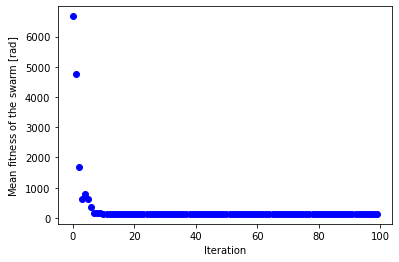

In [14]:
x = np.arange(0,len(particle_positions_history_mean),1)
plt.scatter(x, particle_positions_history_mean, color = 'blue')
plt.xlabel("steering")
plt.xlabel(r"Iteration")
plt.ylabel(r"Mean fitness of the swarm $ \rm [rad]$")

In [148]:
res = sc.norm.fit(pso.particle_positions_history[len(pso.particle_positions_history)-1])
res

(0.09881319387734996, 0.0028138296511636893)

In [22]:
proposed_radius = self.model4.kinematik_model_radius(self.position[0])
print('proposed radius', proposed_radius)
mean = np.full(self.x_vect_ref.shape[0], proposed_radius).reshape(-1,1)


lhd_out = sc.norm.logpdf(self.x_vect_ref, loc= mean, scale= self.position[1])


#print("np.full",end_time1-start_time1)
#print("lhdout",end_time2-end_time1)

# then we sum lhd_out (be careful here, we are summing instead of multiplying
# because we are dealing with the log-likelihood, instead of the raw likelihood).
lhd_out = np.sum(lhd_out)
print(lhd_out)

array([[-2.79415220e-06],
       [ 3.03699289e-01],
       [-1.59247341e-30],
       [-9.79988670e-29],
       [ 2.02845784e-01],
       [-7.16740435e-31],
       [-1.10085860e-25],
       [ 3.28309937e-01],
       [-6.66768399e-28],
       [-2.91954501e-29],
       [-6.74116444e-31],
       [-1.84659307e-30],
       [-9.94913333e-31],
       [ 3.32563224e-01],
       [-4.37287479e-03],
       [-2.60031698e-31],
       [-4.02838473e-31],
       [-3.10613085e-24],
       [-5.24507084e-31],
       [-5.24759677e-11]])

In [67]:
dt = 0.05
open_loop_tf = 10000
T_peak = 0.37
T_slope = 0.4


model4 = FourWheelModel(dt, open_loop_tf, T_peak, T_slope)
steering = np.full(data_size,0.1)

for i in range(len(steering)):
    steering[i] += 0 #np.random.normal(0,0.005)

# obtain response and add noise
y_likelihood = np.zeros(data_size)
for i in range(len(steering)):
    y_likelihood[i] = model4.kinematik_model_radius(steering[i])

# x is the data matrix, first column for input and second column for output.
# theta is a vector containing the parameters for the evaluation
# remember theta[0] is a, theta[1] is b and theta[2] is sigma

proposed_radius = model4.kinematik_model_radius(0.1)
print('proposed radius', proposed_radius)
mean = np.full(y_likelihood.shape[0], proposed_radius).reshape(-1,1)


lhd_out = sc.norm.logpdf(y_likelihood, loc= mean, scale= 0.005)

# then we sum lhd_out (be careful here, we are summing instead of multiplying
# because we are dealing with the log-likelihood, instead of the raw likelihood).
lhd_out = np.sum(lhd_out)/10000


print(lhd_out)

proposed radius 15.267759048747639
4.379378833343365


In [ ]:
plt.plot()